In [1]:
import os

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3

# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMapative proteins in order to reduce deative proteins in order to reduce de

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'distributed': True,
    'minibatch_size': 32,
    'num_devices': 3,
    'n_steps': 120001,
    'test_size': 120,
    'test_minibatch_size': 30,
    'test_interval': 5000,
    'test_n_shuf': [1, 8, 16, 32],
    'test_n_seq': [1, 28*6, 28*9, 28*12],
    'display_images': False,
    'display_image_interval': 1000,
    'dont_display_until_loss': 0.45,
    'n_colors': 4,
    'noise_fraction': 0.1,
    'dataset': {
        'buffer_size': 60000,
    },
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': None,
    'lr_warmup_steps': 300,
    'max_lr': 0.0001,
    'min_lr': 0.0001,
    'batch_size_schedule': None,
    'start_accum_steps': 1,
    'end_accum_steps': 30,
    'seq_length': 784,
    'image_width': 28,
    'image_height': 28,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 500,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change
dataset, metadata = tfds.load('mnist', with_info=True, as_supervised=True)
ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(ds_train_original, num_clusters=config['n_colors'], batch_size=1000)


In [5]:
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)

In [6]:
ds_train, ds_test = ds.make_datasets()

In [7]:
# model config
config.model = DotMap({
        'n_colors': config.n_colors,
        'n_enc_a_layers': 3,
        'n_enc_b_layers': 3,
        'ffl_dim': 800,
        'embd_dim': 512,
        'n_dec_layers': 3,
        'dec_dim': 600,
        'n_heads': 4,
        'dropout_rate': 0.1,
        'use_idxs_input': True,
        'architecture': 'anp',
        'position_embedding': 'pos_enc',
        'activation': 'swish',
    })

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=config.max_lr)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

model_name = "cuda6-0.1noise-3l-512w"
print(model_name)

training.wandb_init(config, model_name, resume=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda6-0.1noise-3l-512w


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxeonyx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
config.training_mode = 'combination'
training_loop = training.TrainingLoop(config, viz, model, optimizer, ds, ds_train_dist, ds_test, schedules.batch_size_schedule(config), model_name)


seq shape: (10, 392)
seq shape: (10, 392)


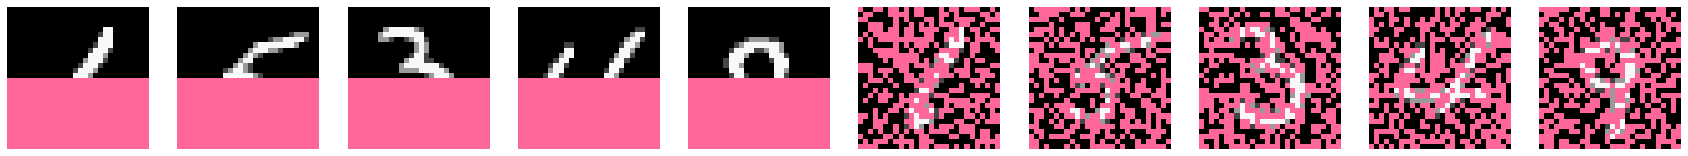

seq shape: (10, 784)
seq shape: (10, 784)


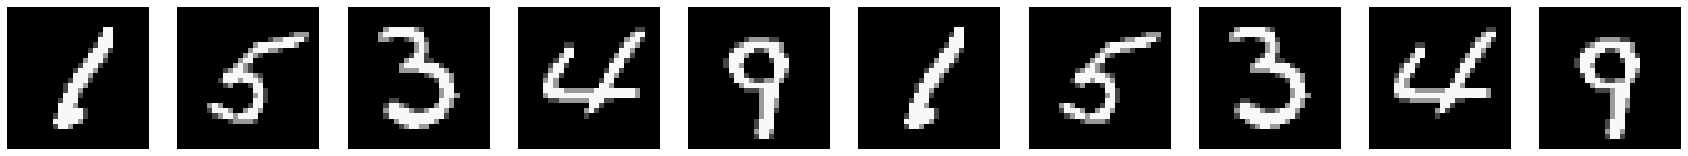

/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-r6Gz9mJU-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall:1", shape=(None, 512), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/clarkemaxw/.cache/pypoetry/virtualenvs/msc-r6Gz9mJU-py3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("StatefulPartitionedCall_1:2", shape=(None,), dtype=int32), values=Tensor("StatefulPartitionedCall_1:1", shape=(None, 512), dtype=float32), dense_shape=Tensor("StatefulPartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This m

INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 63 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:

with strategy.scope():
    training_loop.train()

seq shape: (10, 392)
seq shape: (10, 392)


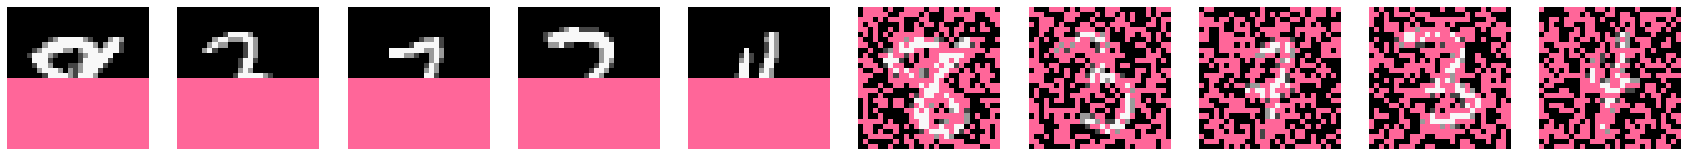

seq shape: (10, 784)
seq shape: (10, 784)


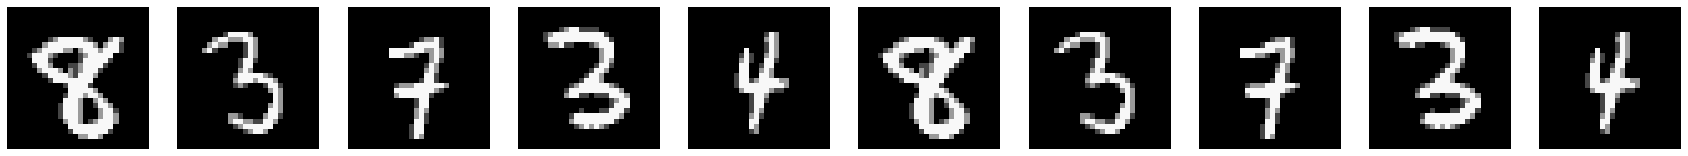

seq shape: (10, 784)
seq shape: (10, 784)


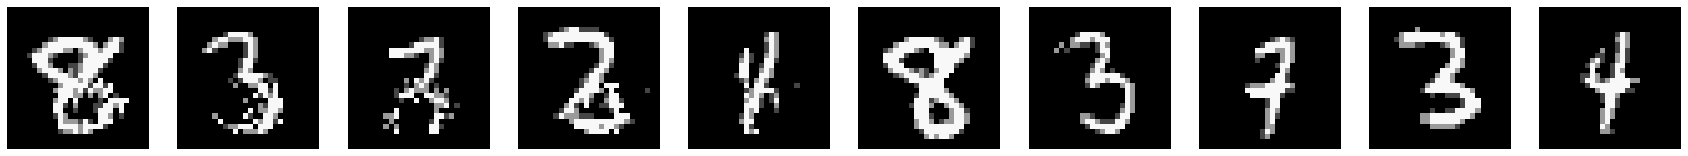

seq shape: (10, 784)
seq shape: (10, 784)


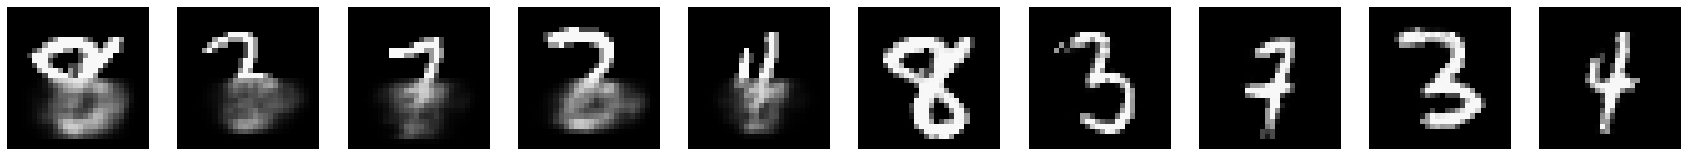

seq shape: (10, 784, 3)
seq shape: (10, 784, 3)


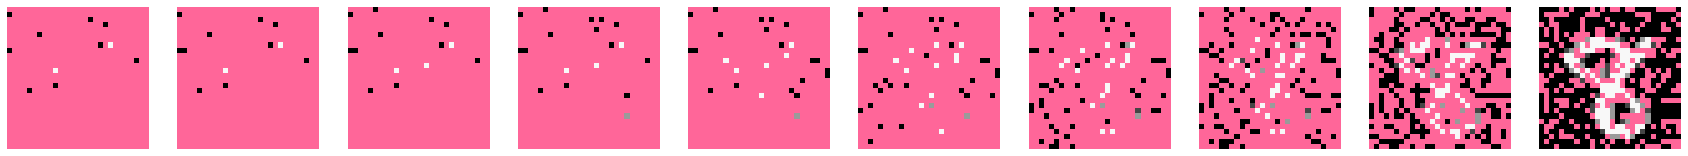

seq shape: (10, 784)
seq shape: (10, 784)


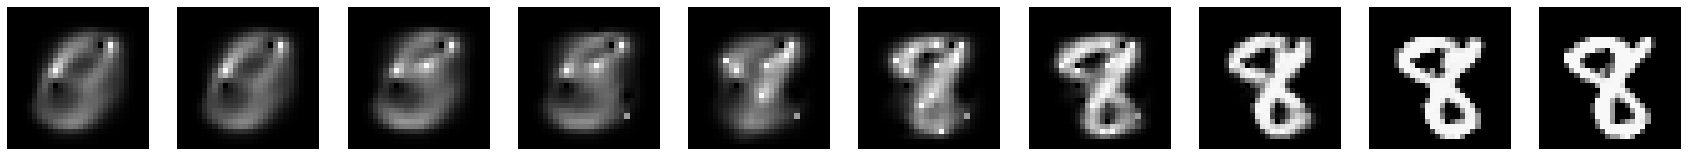

seq shape: (10, 784, 3)
seq shape: (10, 784, 3)


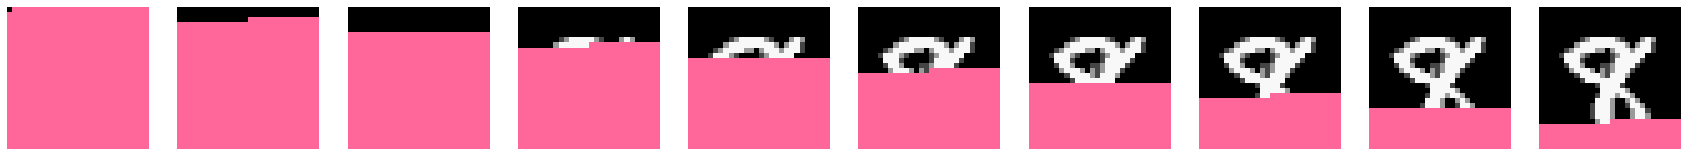

seq shape: (10, 784)
seq shape: (10, 784)


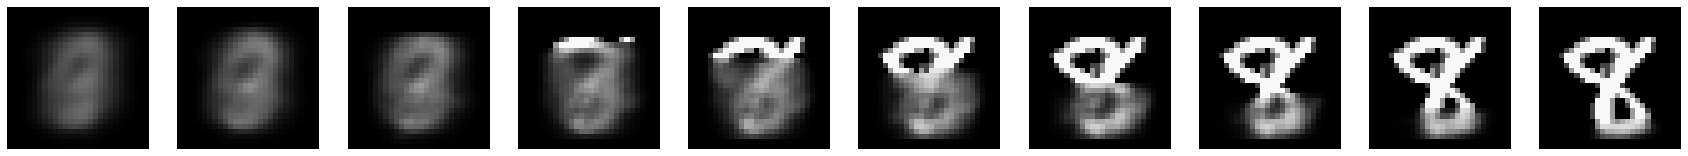

seq shape: (10, 392)
seq shape: (10, 392)


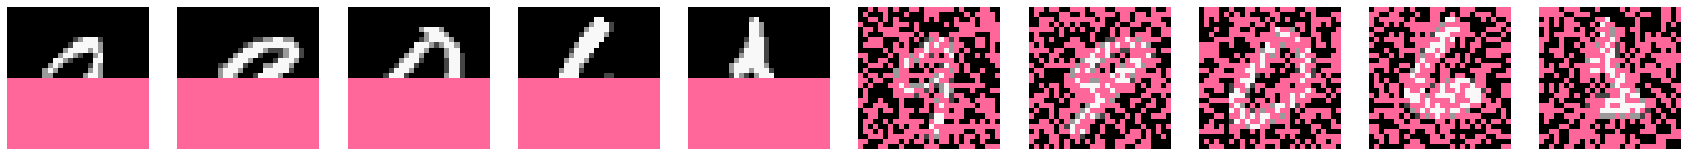

seq shape: (10, 784)
seq shape: (10, 784)


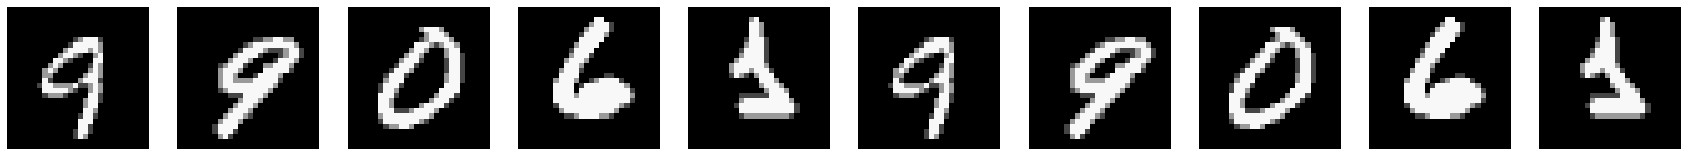

seq shape: (10, 784)
seq shape: (10, 784)


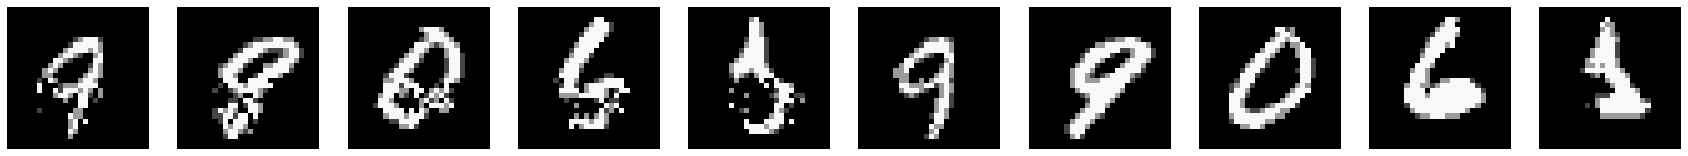

seq shape: (10, 784)
seq shape: (10, 784)


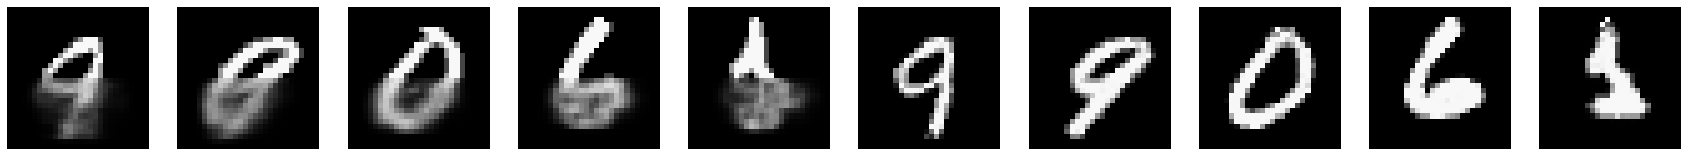

seq shape: (10, 784, 3)
seq shape: (10, 784, 3)


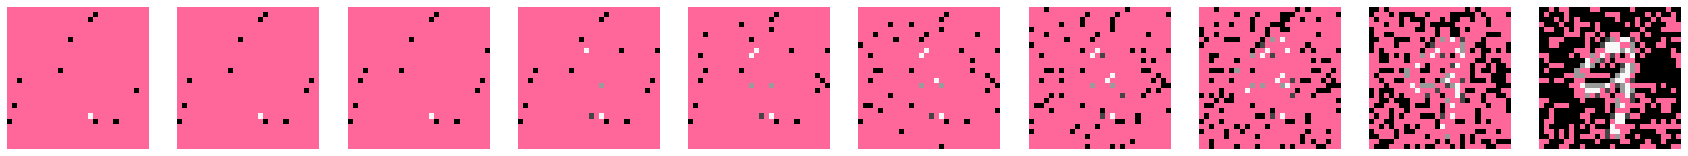

seq shape: (10, 784)
seq shape: (10, 784)


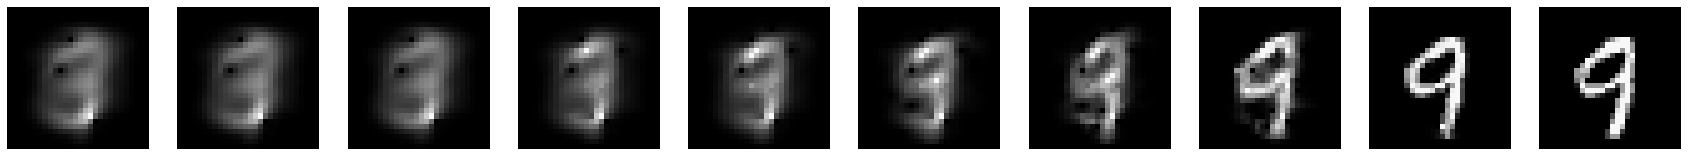

seq shape: (10, 784, 3)
seq shape: (10, 784, 3)


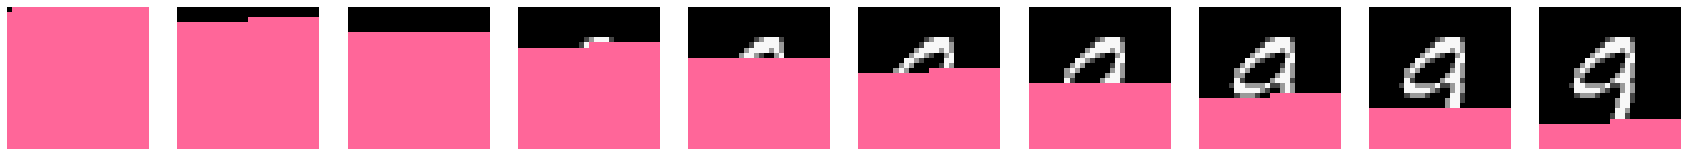

seq shape: (10, 784)
seq shape: (10, 784)


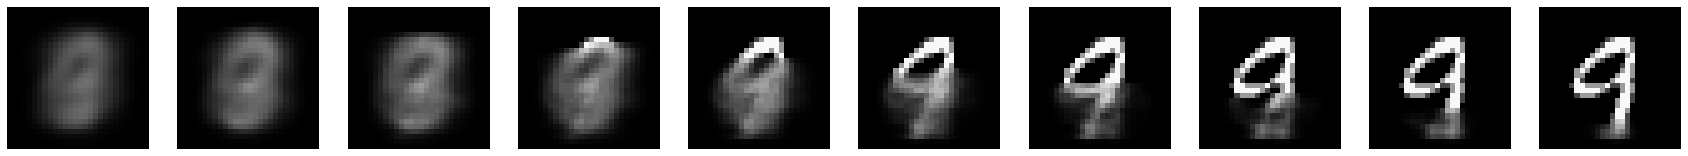

In [12]:
training_loop.process_batch(show_input=True)
training_loop.new_test_batch()
training_loop.process_batch(show_input=True)


In [13]:
model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/cuda6-0.1noise-3l-512w/assets


INFO:tensorflow:Assets written to: models/cuda6-0.1noise-3l-512w/assets


n = 1
seq shape: (10, 1)
seq shape: (10, 1)


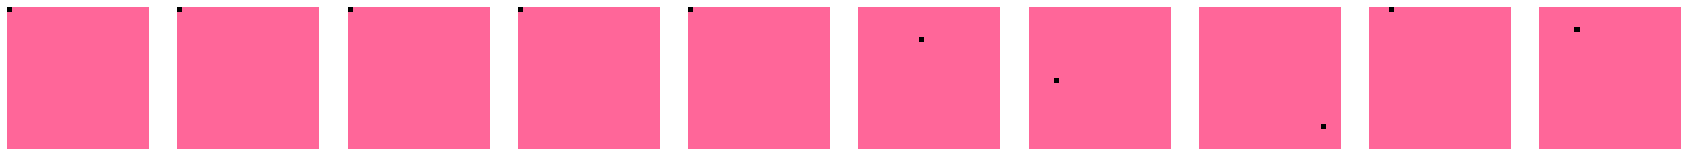

seq shape: (10, 784)
seq shape: (10, 784)


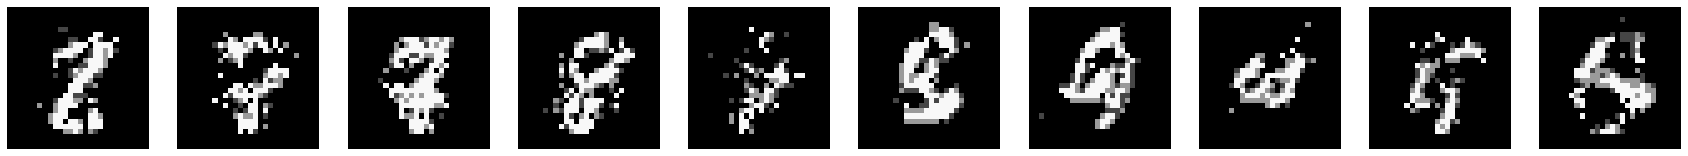

In [14]:
training_loop.many_autoregressive(n_seq=[1])

n = 1
seq shape: (10, 1)
seq shape: (10, 1)


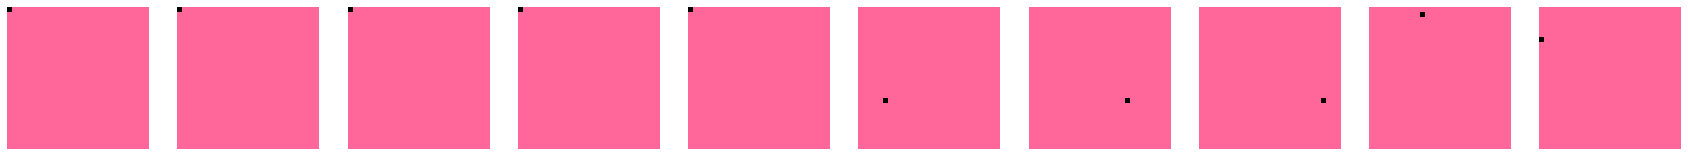

seq shape: (10, 784)
seq shape: (10, 784)


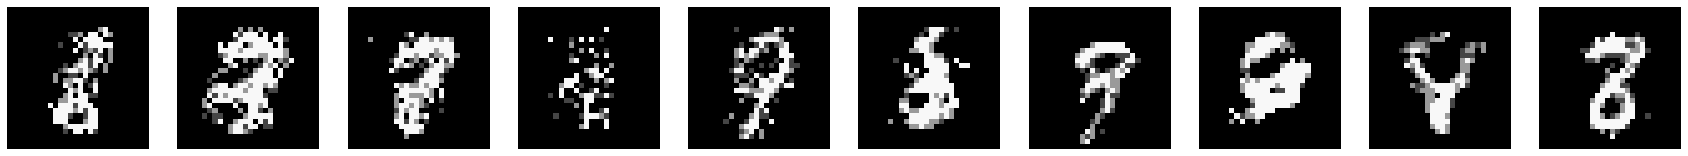

In [15]:
training_loop.new_test_batch()
training_loop.many_autoregressive(n_seq=[1])